In [1]:
!pip install opencv-python matplotlib imageio gdown tensorflow

In [5]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [6]:
tf.config.list_physical_devices('GPU')

[]

DATA LOADING FUNCTIONS

In [4]:
import gdown

In [5]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

Downloading...
From (original): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
From (redirected): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL&confirm=t&uuid=22e2d82f-a541-461c-b852-e084030a0cca
To: C:\Users\vivek\data.zip
 21%|████████████████▏                                                             | 88.1M/423M [00:09<00:32, 10.3MB/s]

KeyboardInterrupt: 

In [7]:
 def load_video(path:str) -> List[float]: 

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()
    
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [8]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [9]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [10]:
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [11]:
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    #file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [12]:
test_path = '.\\data\\s1\\bbal6n.mpg'
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]
frames, alignments = load_data(tf.convert_to_tensor(test_path))

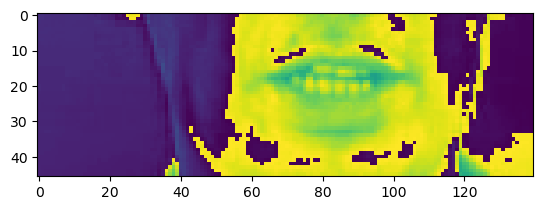

In [13]:
plt.imshow(frames[40])

In [14]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23], dtype=int64)>

In [15]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [16]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

CREATING DATA PIPELINE

In [17]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split 
train = data.take(450)
test = data.skip(450)

In [18]:
len(test)


50

In [19]:
frames, alignments = data.as_numpy_iterator().next()


In [20]:
len(frames)


2

In [21]:
sample = data.as_numpy_iterator()


In [22]:
val = sample.next(); val[0]

array([[[[[1.5334007 ],
          [1.4620796 ],
          [1.4264191 ],
          ...,
          [0.24962336],
          [0.28528383],
          [0.28528383]],

         [[1.569061  ],
          [1.4620796 ],
          [1.3907588 ],
          ...,
          [0.24962336],
          [0.28528383],
          [0.28528383]],

         [[1.4620796 ],
          [1.4620796 ],
          [1.4264191 ],
          ...,
          [0.35660478],
          [0.24962336],
          [0.24962336]],

         ...,

         [[1.0341539 ],
          [1.0341539 ],
          [1.0341539 ],
          ...,
          [0.03566048],
          [0.03566048],
          [0.03566048]],

         [[0.99849343],
          [0.99849343],
          [0.99849343],
          ...,
          [0.03566048],
          [0.03566048],
          [0.03566048]],

         [[0.99849343],
          [0.99849343],
          [0.99849343],
          ...,
          [0.03566048],
          [0.03566048],
          [0.        ]]],


        [[[1.4264

In [23]:
fv = (val[0][1].astype(np.uint8) * 255).squeeze()
imageio.mimsave('./animation.gif', fv, duration=100)

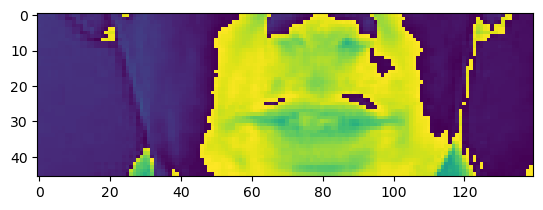

In [24]:
plt.imshow(val[0][0][35])


In [25]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'place red by x three soon'>

In [26]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler


In [27]:
data.as_numpy_iterator().next()[0][0].shape


(75, 46, 140, 1)

In [27]:
from keras.models import Sequential
from keras.layers import Conv3D, Activation, MaxPool3D, TimeDistributed, Flatten, Bidirectional, LSTM, Dropout, Dense
from keras.initializers import Orthogonal

model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75, 46, 140, 1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer=Orthogonal(), return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer=Orthogonal(), return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size() + 1, kernel_initializer='he_normal', activation='softmax'))


C:\Users\vivek\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [28]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                      │ (None, 75, 46, 140, 128)    │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 75, 46, 140, 128)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d (MaxPooling3D)         │ (None, 75, 23, 70, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_1 (Conv3D)                    │ (None, 75, 23, 70, 256)     │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 75, 23, 70, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_1 (MaxPooling3D)       │ (None, 75, 11, 35, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_2 (Conv3D)                    │ (None, 75, 11, 35, 75)      │         518,475 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 75, 11, 35, 75)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_2 (MaxPooling3D)       │ (None, 75, 5, 17, 75)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 75, 6375)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 75, 256)             │       6,660,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 75, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 75, 256)             │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 75, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 75, 41)              │          10,537 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,471,924 (32.32 MB)

 Trainable params: 8,471,924 (32.32 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
yhat = model.predict(val[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


In [30]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])


<tf.Tensor: shape=(), dtype=string, numpy=b'88888888888wwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwcccccccccc'>

In [31]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'88888888888wwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwcccccccccc'>

In [32]:
model.input_shape


(None, 75, 46, 140, 1)

In [33]:
model.output_shape


(None, 75, 41)

In [34]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [35]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss


In [33]:
print(batch_len)

NameError: name 'batch_len' is not defined

In [36]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.shape(y_true)[0]
    input_length = tf.shape(y_pred)[1]  # Time steps (should be 75)
    label_length = tf.shape(y_true)[1]  # Length of the labels

    input_length = tf.fill([batch_len, 1], input_length)  # Ensure correct shape
    label_length = tf.fill([batch_len, 1], label_length)

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss


In [37]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, input_length=tf.fill(yhat.shape[0], 75), greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [38]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [39]:
checkpoint_callback = ModelCheckpoint(os.path.join('models', 'checkpoint.weights.h5'), monitor='loss', save_weights_only=True)

In [40]:
schedule_callback = LearningRateScheduler(scheduler)


In [41]:
example_callback = ProduceExample(test)


In [42]:
pip show tensorflow


Name: tensorflow
Version: 2.16.1
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: C:\Users\vivek\anaconda3\Lib\site-packages
Requires: tensorflow-intel
Required-by: tf_keras
Note: you may need to restart the kernel to use updated packages.


In [43]:
model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/100



InvalidArgumentError: Graph execution error:

Detected at node sequential_1/time_distributed_1/Reshape_74 defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\vivek\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\vivek\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\vivek\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 701, in start

  File "C:\Users\vivek\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\vivek\anaconda3\Lib\asyncio\windows_events.py", line 321, in run_forever

  File "C:\Users\vivek\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\vivek\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\vivek\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\vivek\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 534, in dispatch_queue

  File "C:\Users\vivek\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 523, in process_one

  File "C:\Users\vivek\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 429, in dispatch_shell

  File "C:\Users\vivek\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 767, in execute_request

  File "C:\Users\vivek\anaconda3\Lib\site-packages\ipykernel\ipkernel.py", line 429, in do_execute

  File "C:\Users\vivek\anaconda3\Lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "C:\Users\vivek\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3051, in run_cell

  File "C:\Users\vivek\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3106, in _run_cell

  File "C:\Users\vivek\anaconda3\Lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "C:\Users\vivek\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3311, in run_cell_async

  File "C:\Users\vivek\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3493, in run_ast_nodes

  File "C:\Users\vivek\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3553, in run_code

  File "C:\Users\vivek\AppData\Local\Temp\ipykernel_6292\3536403359.py", line 1, in <module>

  File "C:\Users\vivek\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "C:\Users\vivek\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 329, in fit

  File "C:\Users\vivek\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 122, in one_step_on_iterator

  File "C:\Users\vivek\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 110, in one_step_on_data

  File "C:\Users\vivek\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 57, in train_step

  File "C:\Users\vivek\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "C:\Users\vivek\anaconda3\Lib\site-packages\keras\src\layers\layer.py", line 826, in __call__

  File "C:\Users\vivek\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "C:\Users\vivek\anaconda3\Lib\site-packages\keras\src\ops\operation.py", line 48, in __call__

  File "C:\Users\vivek\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "C:\Users\vivek\anaconda3\Lib\site-packages\keras\src\models\sequential.py", line 206, in call

  File "C:\Users\vivek\anaconda3\Lib\site-packages\keras\src\models\functional.py", line 199, in call

  File "C:\Users\vivek\anaconda3\Lib\site-packages\keras\src\ops\function.py", line 151, in _run_through_graph

  File "C:\Users\vivek\anaconda3\Lib\site-packages\keras\src\models\functional.py", line 583, in call

  File "C:\Users\vivek\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "C:\Users\vivek\anaconda3\Lib\site-packages\keras\src\layers\layer.py", line 826, in __call__

  File "C:\Users\vivek\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "C:\Users\vivek\anaconda3\Lib\site-packages\keras\src\ops\operation.py", line 48, in __call__

  File "C:\Users\vivek\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "C:\Users\vivek\anaconda3\Lib\site-packages\keras\src\layers\rnn\time_distributed.py", line 108, in call

  File "C:\Users\vivek\anaconda3\Lib\site-packages\keras\src\layers\rnn\time_distributed.py", line 108, in <listcomp>

  File "C:\Users\vivek\anaconda3\Lib\site-packages\keras\src\layers\rnn\time_distributed.py", line 102, in step_function

  File "C:\Users\vivek\anaconda3\Lib\site-packages\keras\src\layers\reshaping\flatten.py", line 54, in call

  File "C:\Users\vivek\anaconda3\Lib\site-packages\keras\src\ops\numpy.py", line 4527, in reshape

  File "C:\Users\vivek\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\numpy.py", line 1618, in reshape

Only one input size may be -1, not both 0 and 1
	 [[{{node sequential_1/time_distributed_1/Reshape_74}}]] [Op:__inference_one_step_on_iterator_31226]

In [44]:
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

Downloading...
From (original): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y
From (redirected): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y&confirm=t&uuid=733ff764-f56d-46b0-8ebc-104737373958
To: C:\Users\vivek\checkpoints.zip

  0%|                                                                                      | 0.00/94.5M [00:00<?, ?B/s]
  1%|▍                                                                             | 524k/94.5M [00:00<00:49, 1.88MB/s]
  2%|█▎                                                                           | 1.57M/94.5M [00:00<00:20, 4.59MB/s]
  3%|██▌                                                                          | 3.15M/94.5M [00:00<00:13, 6.97MB/s]
  5%|███▊                                                                         | 4.72M/94.5M [00:01<00:19, 4.60MB/s]
  7%|█████▏                                                                       | 6.29M/94.5M [00:01<00:14, 5.98MB/s]
  8%|█████▉

['models\\checkpoint.index',
 'models\\__MACOSX/._checkpoint.index',
 'models\\checkpoint.data-00000-of-00001',
 'models\\__MACOSX/._checkpoint.data-00000-of-00001',
 'models\\checkpoint',
 'models\\__MACOSX/._checkpoint']

In [46]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, Activation, MaxPool3D, TimeDistributed, Flatten, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.initializers import Orthogonal
import os

def convert_checkpoint_to_h5(checkpoint_dir, output_file):
    # Ensure the checkpoint directory exists
    if not os.path.exists(checkpoint_dir):
        raise FileNotFoundError(f"Checkpoint directory {checkpoint_dir} not found")

    # Find the checkpoint file
    checkpoint_file = os.path.join(checkpoint_dir, 'checkpoint')
    if not os.path.exists(checkpoint_file):
        raise FileNotFoundError(f"Checkpoint file not found in {checkpoint_dir}")

    # Load the checkpoint
    latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
    if latest_checkpoint is None:
        raise ValueError(f"No checkpoint found in {checkpoint_dir}")

    # Recreate your model architecture
    model = Sequential([
        Conv3D(128, 3, input_shape=(75, 46, 140, 1), padding='same'),
        Activation('relu'),
        MaxPool3D((1, 2, 2)),
        Conv3D(256, 3, padding='same'),
        Activation('relu'),
        MaxPool3D((1, 2, 2)),
        Conv3D(75, 3, padding='same'),
        Activation('relu'),
        MaxPool3D((1, 2, 2)),
        TimeDistributed(Flatten()),
        Bidirectional(LSTM(128, kernel_initializer=Orthogonal(), return_sequences=True)),
        Dropout(.5),
        Bidirectional(LSTM(128, kernel_initializer=Orthogonal(), return_sequences=True)),
        Dropout(.5),
        Dense(char_to_num.vocabulary_size() + 1, kernel_initializer='he_normal', activation='softmax')
    ])

    # Load the weights from the checkpoint
    model.load_weights(latest_checkpoint)

    # Save the model in .h5 format
    model.save(output_file)
    print(f"Model has been converted and saved as {output_file}")

# Usage
checkpoint_dir = 'models'
output_file = 'my_model_96_epochs.h5'

try:
    convert_checkpoint_to_h5(checkpoint_dir, output_file)
except Exception as e:
    print(f"An error occurred: {str(e)}")

An error occurred: File format not supported: filepath=models\checkpoint. Keras 3 only supports V3 `.keras` and `.weights.h5` files, or legacy V1/V2 `.h5` files.


In [47]:
import tensorflow as tf
import os

def convert_savedmodel_to_h5(saved_model_dir, output_file):
    # Ensure the SavedModel directory exists
    if not os.path.exists(saved_model_dir):
        raise FileNotFoundError(f"SavedModel directory {saved_model_dir} not found")

    # Load the SavedModel
    try:
        model = tf.keras.models.load_model(saved_model_dir)
    except Exception as e:
        print(f"Error loading SavedModel: {str(e)}")
        return

    # Save the model in .h5 format
    try:
        model.save(output_file, save_format='h5')
        print(f"Model has been converted and saved as {output_file}")
    except Exception as e:
        print(f"Error saving model: {str(e)}")

# Usage
saved_model_dir = 'models'
output_file = 'my_model_96_epochs.h5'

try:
    convert_savedmodel_to_h5(saved_model_dir, output_file)
except Exception as e:
    print(f"An error occurred: {str(e)}")

Error loading SavedModel: File format not supported: filepath=models. Keras 3 only supports V3 `.keras` files and legacy H5 format files (`.h5` extension). Note that the legacy SavedModel format is not supported by `load_model()` in Keras 3. In order to reload a TensorFlow SavedModel as an inference-only layer in Keras 3, use `keras.layers.TFSMLayer(models, call_endpoint='serving_default')` (note that your `call_endpoint` might have a different name).


In [1]:
import tensorflow as tf
import keras
import os

# Set the path to your checkpoint files
checkpoint_dir = 'models'
checkpoint_path = os.path.join(checkpoint_dir, 'checkpoint')

# Define your model architecture to match the input shape
def create_model():
    model = keras.Sequential([
        keras.layers.Conv3D(32, kernel_size=(3, 3, 3), activation='relu', input_shape=(75, 46, 140, 1)),
        keras.layers.MaxPooling3D(pool_size=(2, 2, 2)),
        keras.layers.Conv3D(64, kernel_size=(3, 3, 3), activation='relu'),
        keras.layers.MaxPooling3D(pool_size=(2, 2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(10, activation='softmax')  # Adjust the output size if needed
    ])
    return model

# Create a model instance
model = create_model()

# Create a checkpoint instance
ckpt = tf.train.Checkpoint(model=model)

# Restore the weights
ckpt.restore(tf.train.latest_checkpoint(checkpoint_dir)).expect_partial()

# Save the model in H5 format
h5_path = os.path.join(checkpoint_dir, 'model.weights.h5')
model.save(h5_path, save_format='h5')

print(f"Model has been converted and saved to {h5_path}")

# Example of how to use the model for prediction
def predict(model, sample):
    yhat = model.predict(sample)
    return yhat

# Assuming 'sample' is your input data
# sample = ...  # Your input data here
# prediction = predict(model, sample)
# print(prediction)


C:\Users\vivek\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model has been converted and saved to models\model.weights.h5


In [2]:
model.save_weights('models/model.weights.h5')

In [3]:
model.load_weights('models/model.weights.h5')


In [53]:
test_data = test.as_numpy_iterator()

In [ ]:
sample = test_data.next()

In [ ]:
yhat = model.predict(sample[0])

In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()


In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

In [28]:
sample = load_data(tf.convert_to_tensor('.\\data\\s1\\bras9a.mpg'))

In [29]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]

In [30]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


In [32]:
import tensorflow as tf

# Assuming yhat has shape (batch_size, time_steps, num_classes)
yhat_transposed = tf.transpose(yhat, perm=[1, 0, 2])

decoded = tf.keras.backend.ctc_decode(
    yhat_transposed, 
    input_length=[75], 
    greedy=True
)[0][0].numpy()

InvalidArgumentError: {{function_node __wrapped__Transpose_device_/job:localhost/replica:0/task:0/device:CPU:0}} transpose expects a vector of size 2. But input(1) is a vector of size 3 [Op:Transpose]

In [34]:
yhat_transposed = tf.transpose(yhat, perm=[1, 0, 2])

InvalidArgumentError: {{function_node __wrapped__Transpose_device_/job:localhost/replica:0/task:0/device:CPU:0}} transpose expects a vector of size 2. But input(1) is a vector of size 3 [Op:Transpose]

In [33]:
print("yhat shape:", tf.shape(yhat))
print("yhat_transposed shape:", tf.shape(yhat_transposed))

yhat shape: tf.Tensor([ 1 10], shape=(2,), dtype=int32)


NameError: name 'yhat_transposed' is not defined

In [31]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

InvalidArgumentError: {{function_node __wrapped__Transpose_device_/job:localhost/replica:0/task:0/device:CPU:0}} transpose expects a vector of size 2. But input(1) is a vector of size 3 [Op:Transpose]

In [35]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


NameError: name 'decoded' is not defined